In [ ]:
#%% Setup

# Import necessary packages
import datetime
import flopy
import flopy.utils.binaryfile as bf
import numpy as np
import os
import pandas as pd
import rasterio as rio

In [162]:
#%% # Load DRN characteristics

# Define needed paths and model name
cwd = os.getcwd()   #where test files are stored (github)
# drn_data = os.path.join(cwd, 'test_files', 'busca_drain_specifiche_celle.csv') # DRN characteristics
model_ws = os.path.join(cwd, 'test_files', 'drn_transient')
model_name = 'test_drn_transient'

# Load original .drn file, load DRAIN cells characteristics and
# transform the drn structure in flopy (required format for "stress_period_data")
# drn = load_drn_file_transient(os.path.join(model_ws, 'busca_drain_start.drn'))
# drn_sp = pd.read_csv(drn_data)
# flopy adds 1 to layer, row and column, so subtract 1 to them

drn = pd.read_excel(os.path.join(cwd, 'test_files', 'drn_transient', 'RUN0_15P_FONT_DRN_PARS.xlsx'))

drn.l = 0
drn.r = drn.r - 1
drn.c = drn.c - 1

lenght, width, thickness = 25, 10, 0.5

In [ ]:
# obtain k unifrom distribution
kmin = 1e-6
kmax = 1e-3
k = np.random.default_rng().uniform(low=kmin, high=kmax, size = 148)

In [167]:
drn.conductance = (k*lenght*width)/thickness

In [168]:
stress_period_data = {}
for sp in range(0,20):
    stress_period_data[sp] = drn.iloc[:,:-1].to_numpy().tolist()

In [169]:
ipakcb = 50 #code for cell-by-cell flow data storage

m = flopy.modflow.Modflow(model_name, model_ws = model_ws)
mdrn = flopy.modflow.ModflowDrn(m, stress_period_data=stress_period_data)
mdrn.ipakcb = 50
mdrn.filenames = os.path.join(model_ws, f'{model_name}.drn')
mdrn.write_file(check = False)

In [ ]:
# run


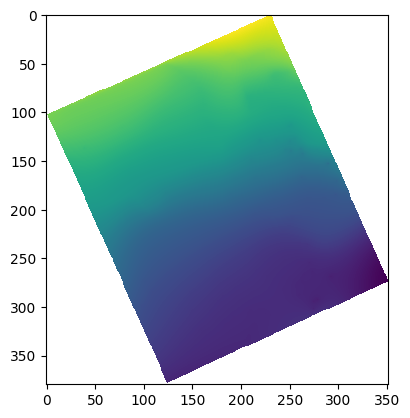

In [ ]:
# load head file
hf = flopy.utils.HeadFile(os.path.join(cwd, 'test_files', 'drn_transient', 'RUN0_15P_FONT_results', 'RUN0_15P_FONT.hds'))

# extract stress period 9, timestep 5
sp = 9
ts = 5
hds = hf.get_data(kstpkper=(ts-1, sp-1))

# plot to see if this works
tool = hds[0,:,:].copy()
tool[tool == 999] = np.nan
plt.imshow(tool)

In [219]:
# create the ndarray
nmodels = 50
hds3d = np.ndarray((hds.shape[1], hds.shape[2], nmodels))

In [220]:
# stress period 1, layer 1
hds3d[:,:,0] = hds[0,:,:]

In [226]:
# load the mass balance
cbb = flopy.utils.binaryfile.CellBudgetFile(os.path.join(cwd, 'test_files', 'drn_transient', 'RUN0_15P_FONT_results', 'RUN0_15P_FONT.cbb'))

In [ ]:
# now: only one stress period and times tep, this will have to be done with all of them
saveflux = drn.loc[:,['r','c','reach']].copy()
for sp in range(0,20):
    for ts in range(0,5):
        if sp == 0 and ts > 0:
            pass
        else:
            drains = cbb.get_data(kstpkper = (ts, sp), text = 'DRAIN')
            flux = []
            for r, c in zip(saveflux.r, saveflux.c):
                flux.append(drains[0][0][r][c])
            saveflux[f'sp{sp+1}-ts{ts+1}'] = flux
saveflux.drop(columns=['r','c'], inplace = True)
saveflux = saveflux.pivot_table(columns='reach')

In [ ]:
# export as a raster

upper_left = (1491600.1, 5046099.53)
xsize, ysize = 50, 50
transform = rio.transform.from_origin(upper_left[0], upper_left[1], xsize, ysize)
raster = rio.open(os.path.join(cwd, 'test_files', 'drn_transient', 'RUN0_15P_FONT_results', 'test_result.tiff'), 'w', driver='GTiff',
                    height = tool.shape[0], width = tool.shape[1],
                    count=1, dtype=str(tool.dtype),
                    crs = rio.CRS.from_epsg(3003),
                    transform = transform)
raster.write(tool, 1)
raster.close()

In [ ]:
# pickle
# save the 3d df as pickle

